# Running Spectral Analysis Script

Now we will run the standalone spectral analysis script to demonstrate the same analysis workflow in a modular format.

In [ ]:
# Import and run the spectral analysis script
import sys
import subprocess
import os

# Run the spectral analysis script
try:
    print("Running spectral analysis script...")
    result = subprocess.run([sys.executable, 'spectral_analysis_2.py'], 
                          capture_output=True, text=True, cwd=os.getcwd())
    
    # print("STDOUT:")
    print(result.stdout)
    
    #if result.stderr:
    #    print("STDERR:")
    #    print(result.stderr)
    
    # print(f"Return code: {result.returncode}")
    
except Exception as e:
    print(f"Error running script: {e}")

## Script Results

The spectral analysis script performs the following steps:

1. **Data Loading**: Loads CSPEC and response data from multiple detectors (n3, n6, n7, b0)
2. **Background Fitting**: Fits polynomial background models using intervals (-50, -10) and (30, 100) seconds
3. **Spectrum Extraction**: Extracts source spectrum from interval (1, 2) seconds
4. **Spectral Fitting**: Fits the Band function to the extracted spectrum
5. **Results**: Outputs spectral parameters with uncertainties and fit statistics

### Expected Output:
- Band function parameters: A, Epeak, α, β
- 90% confidence intervals for each parameter
- PGSTAT/DOF fit quality metric
- Plots of fitted spectrum with residuals

The script demonstrates the same analysis workflow as the notebook but in a modular, reusable format that can be easily adapted for other GRB events or analysis configurations.

ValueError: 'yerr' must not contain negative values

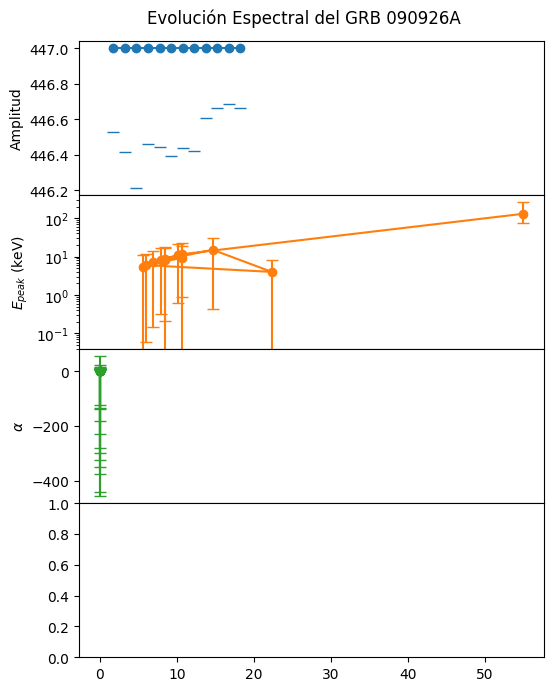

In [23]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'cstat_band_1.5.csv'

# Intenta leer el archivo. Si no existe, muestra un mensaje de error amigable.
try:
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1, filling_values=np.nan)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta.")
    print("Asegúrate de que el archivo .csv se encuentra dentro de una carpeta llamada 'content'.")
    exit()

fig, axes = plt.subplots(
    nrows=4, 
    ncols=1, 
    figsize=(6, 8), 
    sharex=True,
    gridspec_kw={'hspace': 0}
)

fig.suptitle('Evolución Espectral del GRB 090926A', y=0.92)

errorbar_params = {
    'fmt': 'o',
    'linestyle': '-',
    'capsize': 4,
}

# --- Subplot 1: Amplitud ---
ax1 = axes[0]
# y_err es una lista con los errores inferiores y superiores.
# data[:, 6] es la columna de 'amplitude_err_low'
# data[:, 7] es la columna de 'amplitude_err_high'
y_err_amp = [data[:, 6], data[:, 7]] 
# data[:, 2] es la columna 'time_center' (eje x)
# data[:, 5] es la columna 'amplitude' (eje y)
ax1.errorbar(data[:, 2], data[:, 5], yerr=y_err_amp, **errorbar_params)
ax1.set_ylabel('Amplitud')

# --- Subplot 2: Energía Pico (E_peak) ---
ax2 = axes[1]
y_err_epeak = [data[:, 13], data[:, 14]]
ax2.errorbar(data[:, 13], data[:, 14], yerr=y_err_epeak, **errorbar_params, color='C1')
ax2.set_ylabel('$E_{peak}$ (keV)')
ax2.set_yscale('log')

# --- Subplot 3: Índice Fotónico Alpha ---
ax3 = axes[2]
y_err_alpha = [data[:, 12], data[:, 13]]
ax3.errorbar(data[:, 16], data[:, 17], yerr=y_err_alpha, **errorbar_params, color='C2')
ax3.set_ylabel(r'$\alpha$')

# --- Subplot 4: Índice Fotónico Beta ---
ax4 = axes[3]
y_err_beta = [data[:, 15], data[:, 16]]
ax4.errorbar(data[:, 2], data[:, 14], yerr=y_err_beta, **errorbar_params, color='C3')
ax4.set_ylabel(r'$\beta$')

# Configuración final del eje X
ax4.set_xlabel('Tiempo desde el trigger (s)')
plt.xlim(0, 21)

plt.show()

/tmp/user/1000/ipykernel_26043/72802247.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


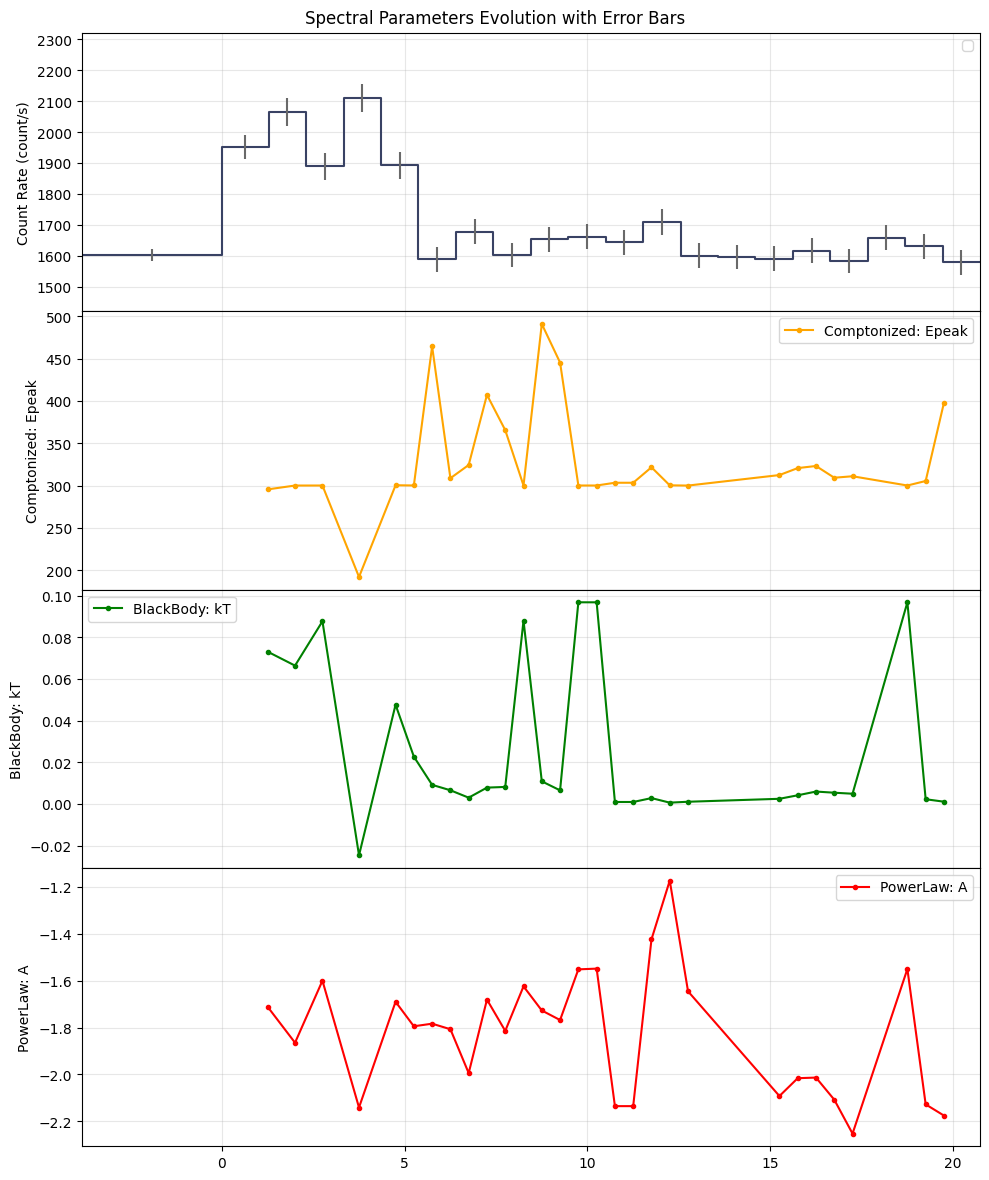

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

from gdt.core.plot.lightcurve import Lightcurve
from gdt.missions.fermi.gbm.phaii import GbmPhaii

file_name = 'cstat_multicomponente.csv'

#params = ('A','Epeak','alpha','beta')
params = ('A','Comptonized: Epeak','BlackBody: kT','PowerLaw: A')

cspec_obj181=GbmPhaii.open('datos/090926181/glg_cspec_b0_bn090926181_v00.pha') ### obj 181 
cspec_obj592=GbmPhaii.open('datos/090424592/glg_cspec_b1_bn090424592_v00.pha') ### obj 592

t_range = (0,20)
e_range = (325,9500)

lc_data181 = cspec_obj181.to_lightcurve(time_range=t_range, energy_range=e_range)
lc_data592 = cspec_obj592.to_lightcurve(time_range=t_range, energy_range=e_range)

lc_data = lc_data592


def plot_parameters_with_error_bars():
    """
    Read cstat_band_1.5.csv and plot A, Epeak, and alpha parameters with error bars.
    Requires pandas and matplotlib to be installed.
    """    
    # Read the CSV file
    df = pd.read_csv(file_name)
    
    # Create figure and axis
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12), sharex=True, gridspec_kw={'hspace': 0})
    lightcurve = Lightcurve(data=lc_data, ax=ax1)

    axes =(ax1, ax2, ax3, ax4)
    
    #params = ('A','Epeak','alpha','beta')
    #params = ('A','Comptonized: Epeak','BlackBody: kT','PowerLaw: A')
    
    colors = ('blue','orange','green', 'red' )
    scales = ('linear', 'linear', 'linear', 'linear')

    for idx, (ax, param, color, scale) in enumerate(zip(axes,params,colors,scales)):
        if idx > 0:
            ax.errorbar(df['time_center'], df[param], 
                     #yerr=[df[f'{param}_err_low']
                     #      , df[f'{param}_err_high']], 
                     fmt='.-', color=color, capsize=3, label=param)
            
            ax.set_ylabel(param)
        
        ax.set_yscale(scale)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Spectral Parameters Evolution with Error Bars')
    plt.tight_layout()
    plt.savefig('imagenes/grafica.png')
    plt.show()


plot_parameters_with_error_bars()